# BreakHis Image Classification with 🤗 Vision Transformers and `TensorFlow`

## Setup & Configuration

In this step, we will define global configurations and parameters, which are used across the whole end-to-end fine-tuning process, e.g. `feature extractor` and `model` we will use. 

In this example we are going to fine-tune the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) a Vision Transformer (ViT) pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224.
There are also [large](https://huggingface.co/google/vit-large-patch16-224-in21k) and [huge](https://huggingface.co/google/vit-huge-patch14-224-in21k) flavors of original ViT.

In [1]:
from pathlib import Path
n_splits = 5

cwd = Path().absolute()
results_path = cwd / 'results_good'


results_path

PosixPath('/home/miki/repos/uz/breakhis/vcs/results_good')

In [2]:
from datasets import load_dataset
import json
# from keras.utils import to_categorical
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
# import tensorflow as tf
# import tensorflow_addons as tfa
from transformers import create_optimizer, DefaultDataCollator, AutoImageProcessor, AutoModelForImageClassification


/home/miki/miniconda3/envs/pt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### List all models

In [3]:
output_paths = [os.path.basename(f.path) for f in os.scandir(results_path) if f.is_dir()]

output_paths

['400x_ViT_PT', '400x_ConvNext_PT']

#### Find the best model

In [4]:
import pandas as pd

def find_best_model_idx_and_acc(output_path):
    json_files = [results_path / output_path / f'model_{idx}' / 'all_results.json' for idx in range(n_splits)]
    # csv_files = [results_path / output_path / f'train_metrics_{idx}.csv' for idx in range(n_splits)]
    # csv_files = [results_path / f'train_metrics_{idx}.csv' for idx in range(n_splits)]
    # dataframes = [pd.read_csv(file) for file in csv_files]


    best_model_index = None
    best_f1_score = 0.0

    for i, json_files in enumerate(json_files):
        with open(json_files) as json_file:
            data = json.load(json_file)
            print(f"Model {i}: e_acc: {data['eval_accuracy']:.3f}, e_loss: {data['eval_loss']:.3f}, e_f1: {data['eval_f1']:.3f}")
            f1_score = data["eval_f1"]
            if f1_score > best_f1_score:
                best_f1_score = f1_score
                best_model_index = i

    print(f"Best model index: {best_model_index}, f1_score: {best_f1_score}")
    return best_model_index, best_f1_score

In [29]:
best_models = {}
for output_path in output_paths:
    best_models[str(results_path / output_path)] = (find_best_model_idx_and_acc(output_path))


print(best_models)

Model 0: e_acc: 0.737, e_loss: 1.734, e_f1: 0.814
Model 1: e_acc: 0.855, e_loss: 0.498, e_f1: 0.909
Model 2: e_acc: 0.843, e_loss: 0.325, e_f1: 0.884
Model 3: e_acc: 0.917, e_loss: 0.311, e_f1: 0.935
Model 4: e_acc: 0.905, e_loss: 0.256, e_f1: 0.931
Best model index: 3, f1_score: 0.9351351351351351
Model 0: e_acc: 0.709, e_loss: 1.923, e_f1: 0.798
Model 1: e_acc: 0.805, e_loss: 0.471, e_f1: 0.873
Model 2: e_acc: 0.775, e_loss: 0.372, e_f1: 0.845
Model 3: e_acc: 0.879, e_loss: 0.294, e_f1: 0.911
Model 4: e_acc: 0.925, e_loss: 0.171, e_f1: 0.944
Best model index: 4, f1_score: 0.9441624365482233
{'/home/miki/repos/uz/breakhis/vcs/results_good/400x_ViT_PT': (3, 0.9351351351351351), '/home/miki/repos/uz/breakhis/vcs/results_good/400x_ConvNext_PT': (4, 0.9441624365482233)}


In [30]:
def calculate_mean_metrics(output_path):
    numeric_columns = ['eval_accuracy', 'eval_auc', 'eval_f1', 'eval_loss', 'eval_precision', 'eval_recall', 'train_loss']

    json_files = [results_path / output_path / f'model_{idx}' / 'all_results.json' for idx in range(n_splits)]
    
    data_list = []
    for json_file in json_files:
        with open(json_file) as f:
            data = json.load(f)
            data_list.append({k: v for k, v in data.items() if k in numeric_columns})

    df = pd.DataFrame(data_list)

    mean_metrics = df.mean()
    std_metrics = df.std()

    # print(df)

    metrics = {
        metric_name: {
            "mean": mean_metrics[metric_name],
            "std": std_metrics[metric_name],
        }
        for metric_name in mean_metrics.index
    }

    with open(results_path / output_path / 'train_metrics_mean_with_std.json', 'w') as f:
        json.dump(metrics, f, indent=4)

    metrics["output_path"] = str(results_path / output_path)
    
    return metrics

In [31]:
import pprint

mean_metrics = []
for output_path in output_paths:
    mean_metrics.append(calculate_mean_metrics(output_path))


for m in mean_metrics:
    pprint.pprint(m)
max_f1_score = max(mean_metrics, key=lambda x: x['eval_f1']['mean'])
# max_f1_score

{'eval_accuracy': {'mean': 0.8514589665269506, 'std': 0.07121717313297131},
 'eval_auc': {'mean': 0.9161254921068551, 'std': 0.06848330976095025},
 'eval_f1': {'mean': 0.8945110391846416, 'std': 0.04922378339187619},
 'eval_loss': {'mean': 0.6248468399047852, 'std': 0.6264499938081185},
 'eval_precision': {'mean': 0.8894494691589887, 'std': 0.12285658772769933},
 'eval_recall': {'mean': 0.9143348416289593, 'std': 0.058194222037916736},
 'output_path': '/home/miki/repos/uz/breakhis/vcs/results_good/400x_ViT_PT',
 'train_loss': {'mean': 0.05176268538922009, 'std': 0.0030554208152429045}}
{'eval_accuracy': {'mean': 0.8186527976362301, 'std': 0.08537375241999602},
 'eval_auc': {'mean': 0.8941789495681697, 'std': 0.10369524585892026},
 'eval_f1': {'mean': 0.8743145893123145, 'std': 0.056646033000732794},
 'eval_loss': {'mean': 0.6462929278612137, 'std': 0.7218778472461267},
 'eval_precision': {'mean': 0.8569242747293316, 'std': 0.13261026988471936},
 'eval_recall': {'mean': 0.91185218702865

In [32]:
for mm in mean_metrics:
    print(mm['output_path'], mm['eval_f1']['mean'])

/home/miki/repos/uz/breakhis/vcs/results_good/400x_ViT_PT 0.8945110391846416
/home/miki/repos/uz/breakhis/vcs/results_good/400x_ConvNext_PT 0.8743145893123145


In [33]:
# with open(results_path / f'model_info_{best_model_index}.json', 'r') as f:
best_model_output_path = max_f1_score["output_path"]
best_model_index = best_models[best_model_output_path][0]
with open(results_path / best_model_output_path / f'model_info_{best_model_index}.json', 'r') as f:
    best_model_info = json.load(f)

best_model_info


{'idx': 3,
 'model_id': 'google/vit-base-patch16-224',
 'zoom': 400,
 'n_splits': 5,
 'num_train_epochs': 50,
 'batch_size': 16,
 'learning_rate': 3e-05,
 'weight_decay_rate': 0.005,
 'num_warmup_steps': 0}

In [34]:
print(best_model_output_path)

/home/miki/repos/uz/breakhis/vcs/results_good/400x_ViT_PT


In [36]:
input_path = cwd / f'breakhis_{best_model_info["zoom"]}x'
input_path

PosixPath('/home/miki/repos/uz/breakhis/vcs/breakhis_400x')

In [ ]:
import pandas as pd

csv_files = [results_path / best_model_output_path / f'train_metrics_{idx}.csv' for idx in range(best_model_info["n_splits"])]
dataframes = [pd.read_csv(file) for file in csv_files]


In [ ]:

for df in dataframes:
    df['f1_score'] = df['f1_score'].apply(compute_mean)
    df['val_f1_score'] = df['val_f1_score'].apply(compute_mean)

{'best_metric': 0.31125155091285706, 'best_model_checkpoint': '/home/miki/repos/uz/breakhis/vcs/results/400x_ViT_PT_folds4/model_3/checkpoint-144', 'epoch': 7.0, 'eval_steps': 500, 'global_step': 504, 'is_hyper_param_search': False, 'is_local_process_zero': True, 'is_world_process_zero': True, 'log_history': [{'epoch': 1.0, 'learning_rate': 2.9408333333333334e-05, 'loss': 0.2459, 'step': 72}, {'epoch': 1.0, 'eval_accuracy': 0.9, 'eval_auc': 0.961187584345479, 'eval_f1': 0.9214092140921409, 'eval_loss': 0.3210223615169525, 'eval_precision': 0.9770114942528736, 'eval_recall': 0.8717948717948718, 'eval_runtime': 24.8538, 'eval_samples_per_second': 11.668, 'eval_steps_per_second': 0.764, 'step': 72}, {'epoch': 2.0, 'learning_rate': 2.8808333333333333e-05, 'loss': 0.0942, 'step': 144}, {'epoch': 2.0, 'eval_accuracy': 0.9172413793103448, 'eval_auc': 0.9712550607287448, 'eval_f1': 0.9351351351351351, 'eval_loss': 0.31125155091285706, 'eval_precision': 0.9885714285714285, 'eval_recall': 0.8871

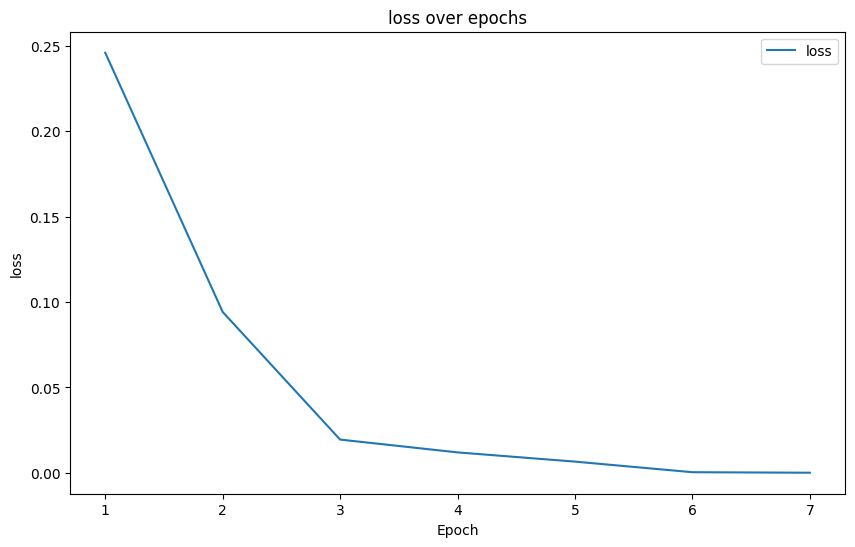

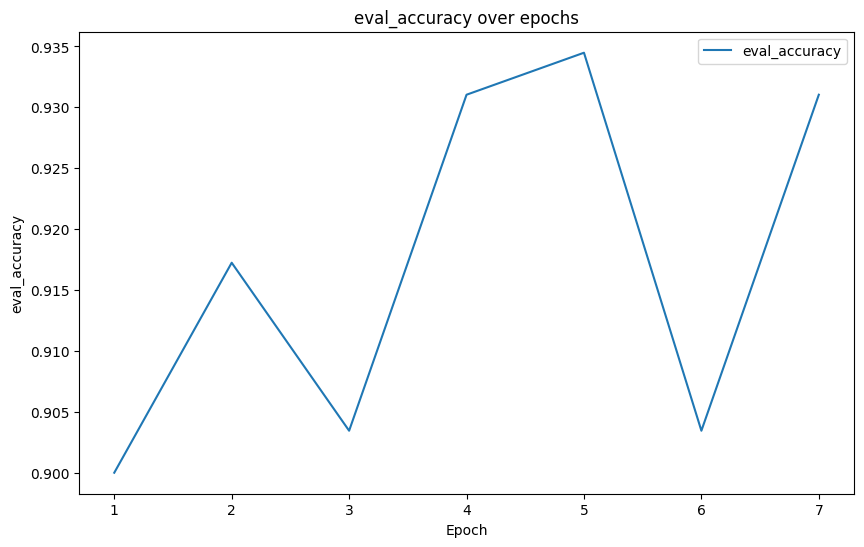

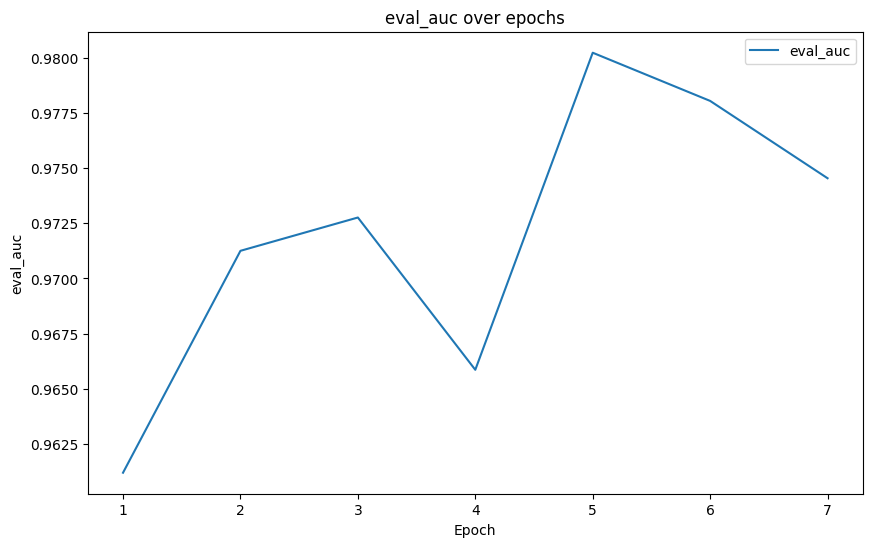

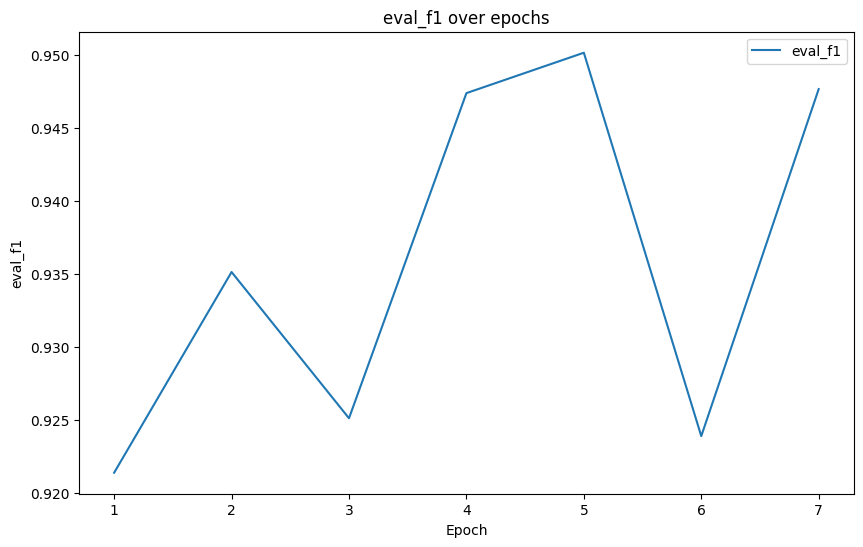

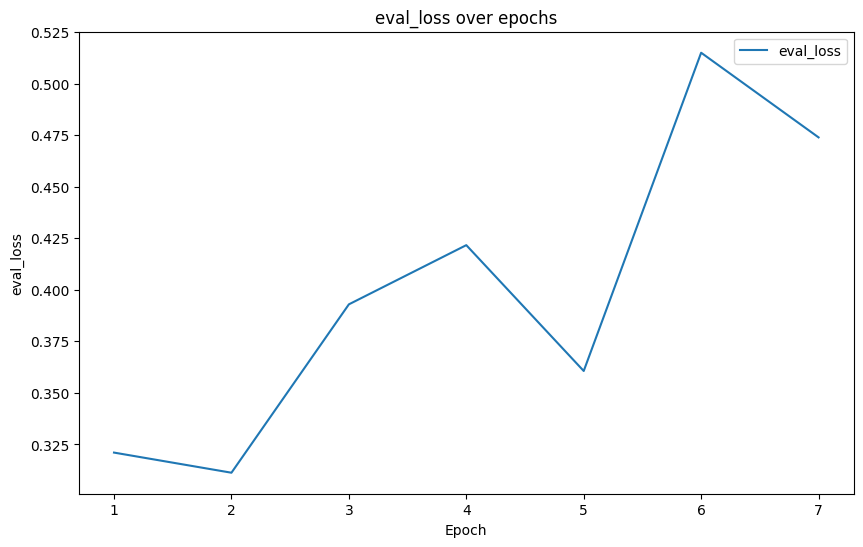

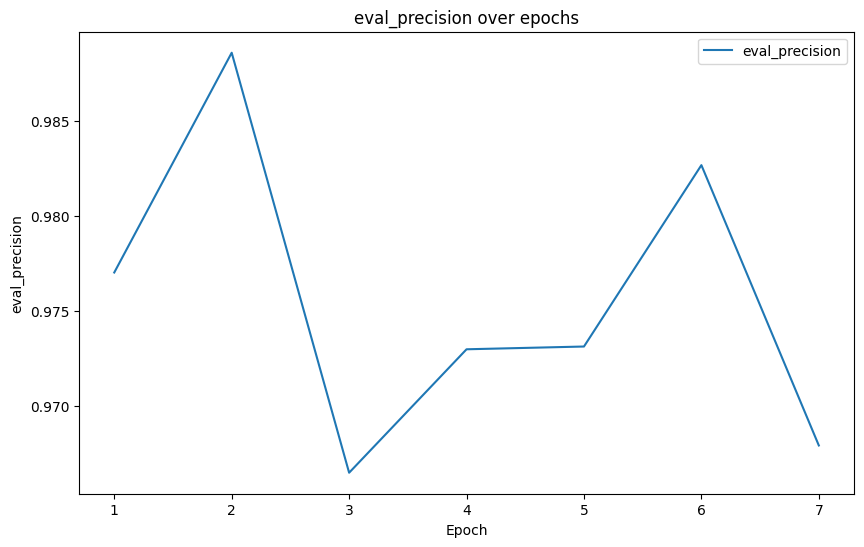

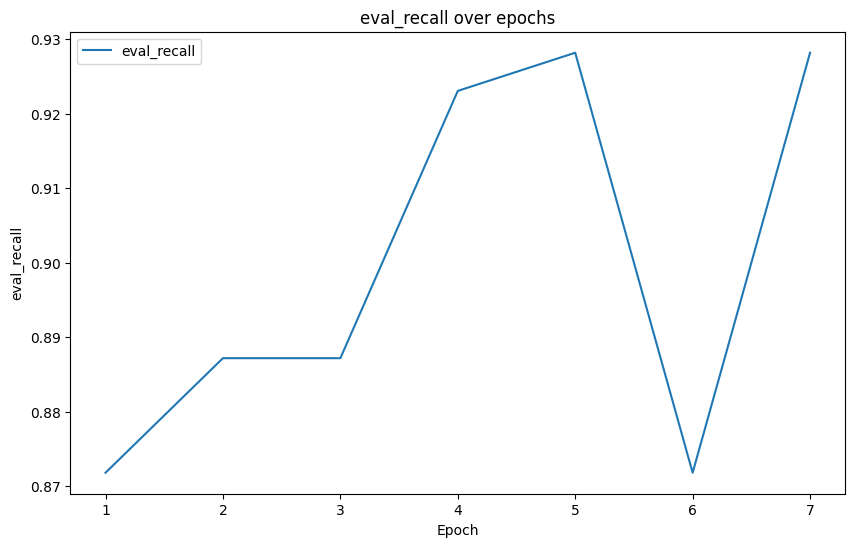

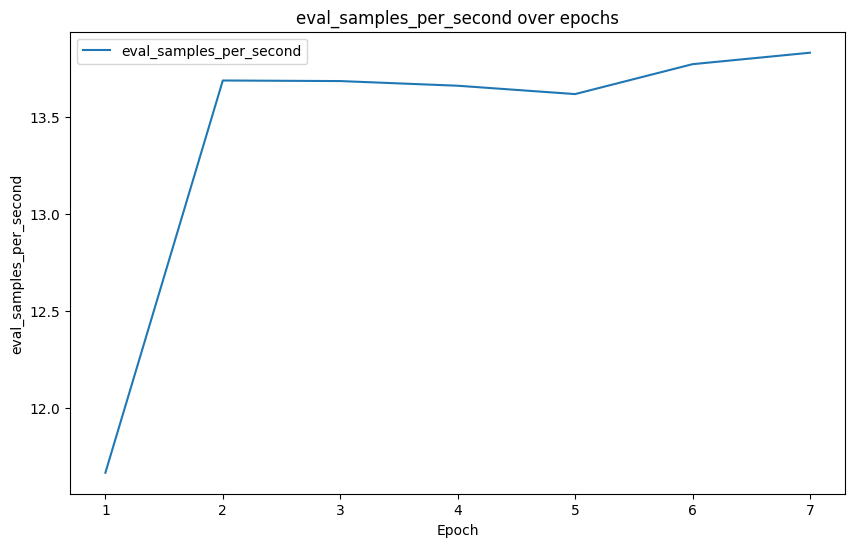

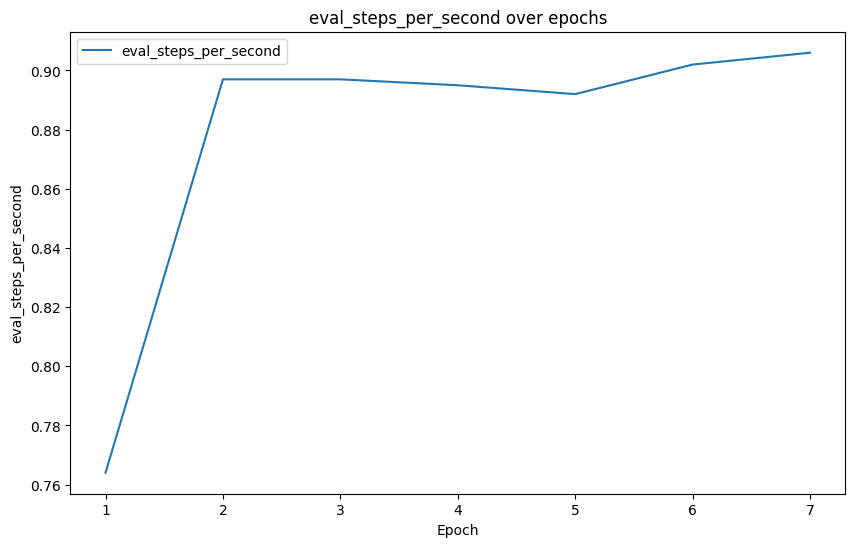

In [44]:
import json
import matplotlib.pyplot as plt

def plot_metrics(file_path):
    # Load JSON data
    with open(file_path, 'r') as file:
        data = json.load(file)
    print(data)
    # Initialize a dictionary to hold all metrics
    metrics = {}

    # Extract metrics
    for entry in data['log_history']:
        for key, value in entry.items():
            if key not in ["epoch", "step", "total_flos", "train_runtime", "eval_runtime", "learning_rate", "train_samples_per_second", "train_steps_per_second", "train_loss"]:
                if key not in metrics:
                    metrics[key] = {'epochs': [], 'values': []}
                metrics[key]['epochs'].append(entry['epoch'])
                metrics[key]['values'].append(value)
    
    # Plot each metric
    for metric, values in metrics.items():
        plt.figure(figsize=(10, 6))
        plt.plot(values['epochs'], values['values'], label=metric)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'{metric} over epochs')
        plt.legend()
        plt.show()

plot_metrics(results_path / best_model_output_path / f'model_{best_model_index}' / 'trainer_state.json')


#### Final evaluation on test dataset

In [ ]:
tf.debugging.disable_traceback_filtering()


image_processor = ViTImageProcessor.from_pretrained(best_model_info['model_id'])


def remove_extra_dim(example):
    example['pixel_values'] = np.squeeze(example['pixel_values'], axis=0)
    return example


def process_example(image):
    inputs = image_processor(image, return_tensors='tf')
    return inputs['pixel_values']


def process_dataset(example):
    example['pixel_values'] = process_example(
        Image.open(example['file_loc']).convert("RGB"))

    # example['pixel_values']=np.squeeze(example['pixel_values'], axis=0)
    example['label'] = to_categorical(example['label'], num_classes=2)
    return example


def load_test_data():
    test_csv = str(input_path / 'test.csv')
    dataset = load_dataset(
        'csv', data_files={'test': test_csv})

    dataset = dataset.map(process_dataset, with_indices=False, num_proc=1)

    print(f"Loaded test dataset: {len(dataset['test'])} samples")

    return dataset.map(remove_extra_dim)


test_dataset = load_test_data()

data_collator = DefaultDataCollator(return_tensors="tf")

test_dataset_tf = test_dataset['test'].to_tf_dataset(
    columns=['pixel_values'],
    label_cols=['label'],
    shuffle=False,
    batch_size=best_model_info['batch_size'],
    collate_fn=data_collator)


In [ ]:
best_model = TFViTForImageClassification.from_pretrained(results_path / best_model_output_path / f'model_{best_model_index}')

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

metrics = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name='auc', from_logits=True),
    tf.keras.metrics.AUC(name='auc_multi', from_logits=True, num_labels=2, multi_label=True),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.Precision(name='precision'),
    tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5),
]

optimizer, _ = create_optimizer(
    init_lr=best_model_info['learning_rate'],
    num_train_steps=best_model_info['num_train_steps'],
    weight_decay_rate=best_model_info['weight_decay_rate'],
    num_warmup_steps=best_model_info['num_warmup_steps'],
)
best_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

results = best_model.evaluate(test_dataset_tf)

In [ ]:
print("Test dataset evaluation results:")
test_metrics = {}
for metric, value in zip(best_model.metrics_names, results):
    print(metric, value)
    if isinstance(value, np.ndarray):
        value = list(value)
        value = [str(v) for v in value]
    else:
        value = str(value)
    test_metrics[metric] = value

with open(results_path / best_model_output_path / 'test_metrics.json', 'w') as test_metrics_json:
    json.dump(test_metrics, test_metrics_json, indent = 4)

#### Let's take a look at the details of the predictions

In [ ]:
preds = best_model.predict(test_dataset_tf)
probabilities = tf.nn.softmax(preds.logits, axis=-1)


In [ ]:
preds

In [ ]:
labels_pred = np.argmax(probabilities, axis=-1)
labels_pred


In [ ]:
np.array(test_dataset['test']['label'])


In [ ]:
# Extract file locations and real labels from the test dataset
file_locs = [example['file_loc'] for example in test_dataset['test']]
labels = [np.argmax(example['label']) for example in test_dataset['test']]

# Create a DataFrame
results_df = pd.DataFrame(
    {'file_loc': file_locs, 'label': labels, 'label_pred': labels_pred})

# Save the DataFrame as a CSV file
results_df.to_csv(results_path / best_model_output_path / f'test_results.csv', index=False)
